In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from matplotlib.colors import ListedColormap
import h5py
import skimage

# a. Auxiliary Functions

In [473]:
directions = [
    (-1, 0),  # North
    (1, 0),   # South
    (0, -1),  # West
    (0, 1),   # East
    (-1, -1), # Northwest
    (-1, 1),  # Northeast
    (1, -1),  # Southwest
    (1, 1),   # Southeast
]

def dfs(grid, visited, row, col):
    cols = grid.shape[1]
    rows = grid.shape[0]
    stack = [(row, col)]
    size = 0  # To track the size of the zone
    while stack:
        r, c = stack.pop()
        if not visited[r][c]:
            visited[r][c] = True
            size += 1  # Increment the size for each cell in the zone
            # Check all adjacent cells
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not visited[nr][nc] and grid[nr][nc]:
                    stack.append((nr, nc))
    return size

def count_zones_and_sizes(grid):
    cols = grid.shape[1]
    rows = grid.shape[0]
    visited = [[False for  _ in range(cols)] for _ in range(rows)]
    zone_sizes = []  # List to keep track of the sizes of each zone
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] and not visited[r][c]:
                # Start a new DFS to find the size of the connected component
                size = dfs(grid, visited, r, c)  # Get the size of the zone
                if size > 10:
                    zone_sizes.append(size)  # Store the size of the zone
                else:
                    pass
    return zone_sizes

# 1. Load the clustered data

In [36]:
data = np.load('F:/Data/Data_HSI/cluster.npy')

colors = ['xkcd:dark mauve', 'xkcd:white',  'xkcd:pale' , 'xkcd:light grey','xkcd:greenish grey']
cmp_init = ListedColormap(colors)

## 1.1 Visualize

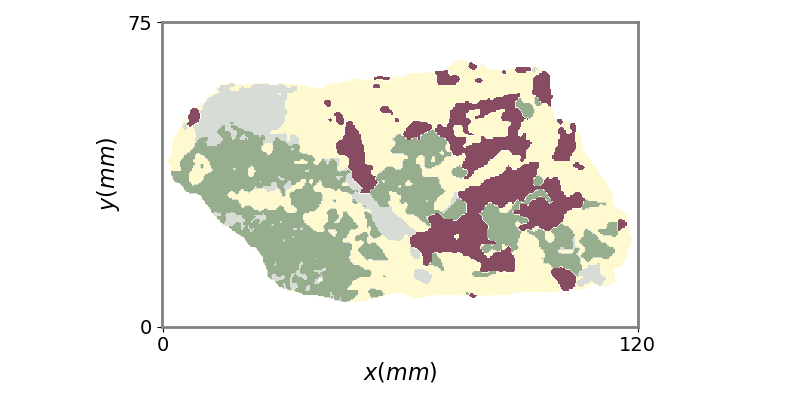

In [444]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.imshow(skimage.filters.median(data), cmap = cmp_init)
ax.set_xlabel(r'$x (mm)$', fontsize = 16)
ax.set_ylabel(r'$y (mm)$', fontsize = 16)
ax.set_xticks([0, 320])
ax.set_xticklabels([0, 120], fontsize = 14)
ax.set_yticks([0, 205])
ax.set_yticklabels([75, 0], fontsize = 14)

fig.tight_layout()

In [89]:
pixel_size = (75/data.shape[0] + 120/data.shape[1])/2

In [90]:
pixel_size # mm

0.3704268292682927

# 2. Perform the SLIC algorithm

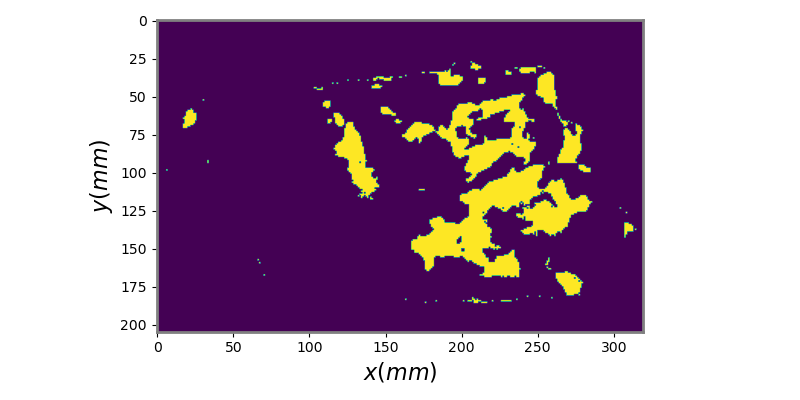

In [488]:
%matplotlib widget
fig, ax = plt.subplots(figsize = (8, 4))

mmap = (data == 0)
ax.imshow(mmap)
# ax.imshow(skimage.segmentation.mark_boundaries(data, data), alpha = 0.2)
ax.set_xlabel(r'$x (mm)$', fontsize = 16)
ax.set_ylabel(r'$y (mm)$', fontsize = 16)
# ax.set_xticks([0, 320])
# ax.set_xticklabels([0, 120], fontsize = 14)
# ax.set_yticks([0, 205])
# ax.set_yticklabels([75, 0], fontsize = 14)

fig.tight_layout()

# 3. Piece d' la resistance

In [445]:
filtered = skimage.filters.median(data)

In [499]:
label = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']
pixel_area = pixel_size**2/100 # mm^2
total_areas = []

for miner in range(len(np.unique(data))):
    mineral_regions = (filtered == miner)
    zone_sizes = np.array(count_zones_and_sizes(mineral_regions))
    total_areas.append(zone_sizes*pixel_area)
    print(len(zone_sizes))

total_areas = np.array(total_areas)

20
1
25
24
15


C:\Users\tomas\AppData\Local\Temp\ipykernel_11764\1562732622.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_areas = np.array(total_areas)


In [494]:
3357*pixel_area

4.606342323207912

In [500]:
total_areas[0]

array([0.02607105, 0.05076993, 0.16740356, 0.2977588 , 0.02744321,
       0.02195457, 0.01783808, 2.13370936, 0.02607105, 0.04802561,
       0.10291203, 0.06174722, 0.01509376, 0.84662294, 0.22640646,
       0.35676169, 4.60634232, 0.03567617, 0.04802561, 0.24836102])

In [506]:
bin_edges

array([ 4. ,  7.6, 11.2, 14.8, 18.4, 22. , 25.6, 29.2, 32.8, 36.4, 40. ])

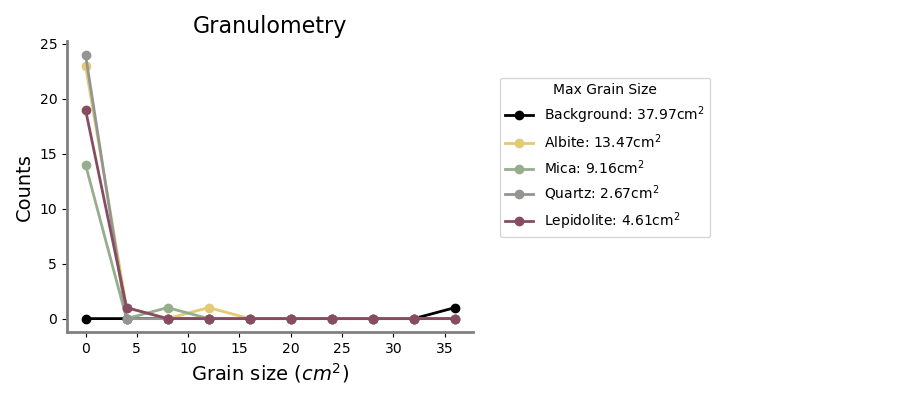

In [535]:
colors = ['xkcd:dark mauve', 'xkcd:black',  'xkcd:sand' , 'xkcd:grey','xkcd:greenish grey']
mineral = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']
seq = [1, 2, 4, 3, 0]

fig, ax = plt.subplots(1, figsize = (9, 4))
for i in seq:
    hist, bin_edges = np.histogram(total_areas[i], bins = 10, range = (0, 40))
    ax.plot(bin_edges[:-1], hist, color = colors[i], label = f'{mineral[i]}: {np.max(total_areas[i]):.2f}' + r'cm$^2$', lw = 2, marker = 'o')
    # ax.hist(total_areas[i], bins = 5, range = (0, 40), color = colors[i], label = mineral[i])
    # current = hist*0
    # ax.fill_between(bin_edges[1:], current, current + hist, color = colors[i])
    # current += hist
ax.legend(bbox_to_anchor = (1.6, 0.6), loc = 'center right', title = "Max Grain Size")
ax.set_xlabel(r'Grain size ($cm^2$)', fontsize = 14)
ax.set_ylabel('Counts', fontsize = 14)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title('Granulometry', fontsize = 16)

fig.tight_layout()
# savefig('graph_grain_all.jpg', dpi = 300, bbox_inches = 'tight')

In [417]:
bin_edges

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40.])

In [142]:
total_areas[1].shape

(21,)

In [355]:
directions = [
    (-1, 0),  # North
    (1, 0),   # South
    (0, -1),  # West
    (0, 1),   # East
    (-1, -1), # Northwest
    (-1, 1),  # Northeast
    (1, -1),  # Southwest
    (1, 1),   # Southeast
]

def dfs(grid, visited, row, col):
    cols = grid.shape[1]
    rows = grid.shape[0]
    stack = [(row, col)]
    size = 0  # To track the size of the zone
    while stack:
        r, c = stack.pop()
        if not visited[r][c]:
            visited[r][c] = True
            size += 1  # Increment the size for each cell in the zone
            # Check all adjacent cells
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not visited[nr][nc] and grid[nr][nc]:
                    stack.append((nr, nc))
    return size

def count_zones_and_sizes(grid):
    cols = grid.shape[1]
    rows = grid.shape[0]
    visited = [[False for  _ in range(cols)] for _ in range(rows)]
    zone_sizes = []  # List to keep track of the sizes of each zone
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] and not visited[r][c]:
                # Start a new DFS to find the size of the connected component
                size = dfs(grid, visited, r, c)  # Get the size of the zone
                zone_sizes.append(size)  # Store the size of the zone
    return zone_sizes

zone_sizes = count_zones_and_sizes(mmap)
print("Zone Count:", len(zone_sizes))
print("Sizes of each contiguous zone:", zone_sizes)

Zone Count: 27
Sizes of each contiguous zone: [27558, 2, 1, 3, 1, 1, 1, 1, 5, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 11, 1]


In [341]:
cols = mmap.shape[1]
rows = mmap.shape[0]
visited = [[False for _ in range(cols)] for _ in range(rows)]

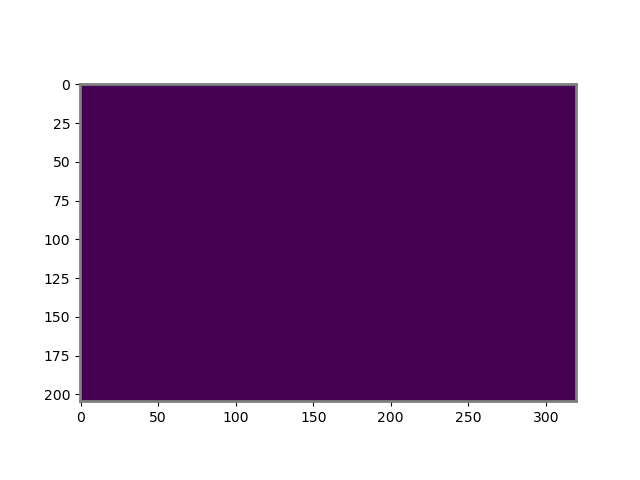

In [345]:
plt.subplots()
plt.imshow(visited)